# Introduction
This notebook contains the basic usage of keras and sklearn on MNIST
There are 5 steps.

1. Stratified shuffling split on training data set
2. Training and validating a CNN
3. Confusion matrix
4. Convolution fileter visualization
5. Saliency map

There are 2 outputs

1. Prediction csv on testing data
2. Keras model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns


from subprocess import check_output
print(check_output(["ls", "/path/to/data/mnist_data/"]).decode("utf8"))

test.csv
train.csv



In [3]:
!pip install yprov4ml

In [4]:
import yprov4ml

In [5]:
# Start the provenance run
yprov4ml.start_run(
    prov_user_namespace="www.example.og",
    experiment_name="saliency_mapping",
    provenance_save_dir="/content/"
)

[codecarbon WARNING @ 12:42:39] Multiple instances of codecarbon are allowed to run at the same time.


In [ ]:
# read input csv file
train_df = pd.read_csv('/path/to/data/mnist_data/train.csv')
test_df = pd.read_csv('/path/to/data/mnist_data/test.csv')

There are 42000 training data and 28000 testing data
Number of occurence for each number in training data (0 stands for 10):
[[   0 4132]
 [   1 4684]
 [   2 4177]
 [   3 4351]
 [   4 4072]
 [   5 3795]
 [   6 4137]
 [   7 4401]
 [   8 4063]
 [   9 4188]]


<Axes: ylabel='count'>

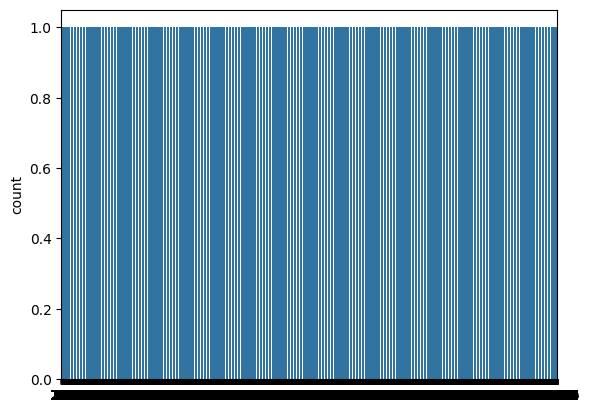

In [7]:
X_train = []
Y_train = []
X_test = []

# reshape training data from rows into images
for index, row in train_df.iterrows():
    X_train.append(row.values[1 : ].reshape((28, 28, 1)))
    Y_train.append(row['label'])

# reshape testing data from rows into images
for index, row in test_df.iterrows():
    X_test.append(row.values.reshape((28, 28, 1)))

# normalization
X_train = np.array(X_train) / 255.
Y_train = np.array(Y_train)
X_test = np.array(X_test) / 255.

print('There are', X_train.shape[0], 'training data and', X_test.shape[0], 'testing data')
print('Number of occurence for each number in training data (0 stands for 10):')
print(np.vstack((np.unique(Y_train), np.bincount(Y_train))).T)
sns.countplot(Y_train)

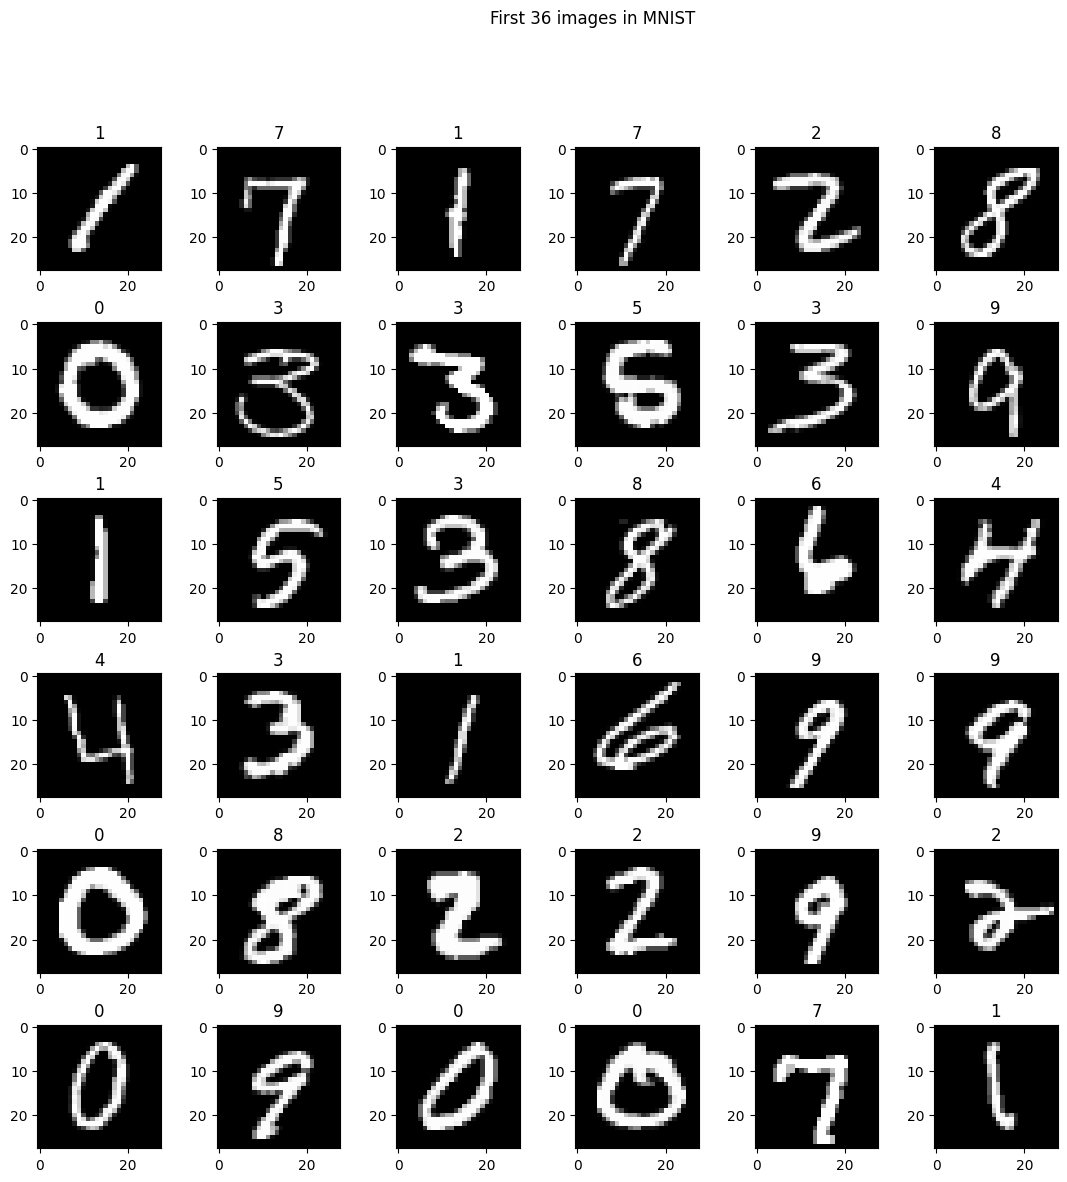

In [8]:
# plot first 36 images in MNIST
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y * 6])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing

# transform training label to one-hot encoding
lb = preprocessing.LabelBinarizer()
lb.fit(Y_train)
Y_train = lb.transform(Y_train)

# split training and validating data
print('Stratified shuffling...')
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=15)
for train_idx, val_idx in sss.split(X_train, Y_train):
    X_train_tmp, X_val = X_train[train_idx], X_train[val_idx]
    Y_train_tmp, Y_val = Y_train[train_idx], Y_train[val_idx]

X_train = X_train_tmp
Y_train = Y_train_tmp
print('Finish stratified shuffling...')

Stratified shuffling...
Finish stratified shuffling...


In [10]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (28, 28, 1)
n_classes = 10

if os.path.exists('keras_model.h5'):
    print('Loading model...')
    model = load_model('keras_model.h5')
else:
    print('Building model...')
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape = img_size, kernel_initializer = 'normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64, (5, 5), kernel_initializer = 'normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

Building model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 0,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False
)

datagen.fit(X_train)

In [12]:
print('Training model...')
model.fit(datagen.flow(X_train, Y_train, batch_size = 1000),
                   epochs = 20,
                   validation_data = (X_val, Y_val),
                   steps_per_epoch = int(X_train.shape[0] / 1000),
                   verbose = 1)
print('Validating model...')
score, acc = model.evaluate(X_val, Y_val, verbose = 1)
print('\nLoss:', score, '\nAcc:', acc)
model.save('keras_model.h5')

Training model...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3602 - loss: 1.8267 - val_accuracy: 0.8620 - val_loss: 0.4647
Epoch 2/20
 1/33 ━━━━━━━━━━━━━━━━━━━━ 28s 904ms/step - accuracy: 0.6490 - loss: 1.0049

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.6490 - loss: 1.0049 - val_accuracy: 0.8690 - val_loss: 0.4720
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7544 - loss: 0.7855 - val_accuracy: 0.9363 - val_loss: 0.2226
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8430 - loss: 0.5143 - val_accuracy: 0.9495 - val_loss: 0.1947
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8526 - loss: 0.4771 - val_accuracy: 0.9519 - val_loss: 0.1575
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8760 - loss: 0.3830 - val_accuracy: 0.9496 - val_loss: 0.1762
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8805 - loss: 0.3875 - val_accuracy: 0.9688 - val_loss: 0.1074
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9200 - loss: 0.2659 - val_accuracy: 0.9700 - val_loss: 0.0997
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9095 - loss: 0.2988 - val_accuracy: 0.9711 - val_loss: 0.09


Loss: 0.06504915654659271 
Acc: 0.9808333516120911


In [13]:
yprov4ml.log_artifact("Classifier", "keras_model.h5")

<ProvEntity: keras_model.h5>

In [14]:
print('Predicting...')
Y_test = model.predict(X_test)
Y_test = lb.inverse_transform(Y_test)
Y_test = [[y] for y in Y_test]
index = [[i] for i in range(1, X_test.shape[0] + 1)]
output_np = np.concatenate((index, Y_test), axis = 1)
output_df = pd.DataFrame(data = output_np, columns = ['ImageId', 'Label'])
output_df.to_csv('out.csv', index = False)

Predicting...
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step


263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


Text(0.5, 21.34715460257995, 'Predicted label')

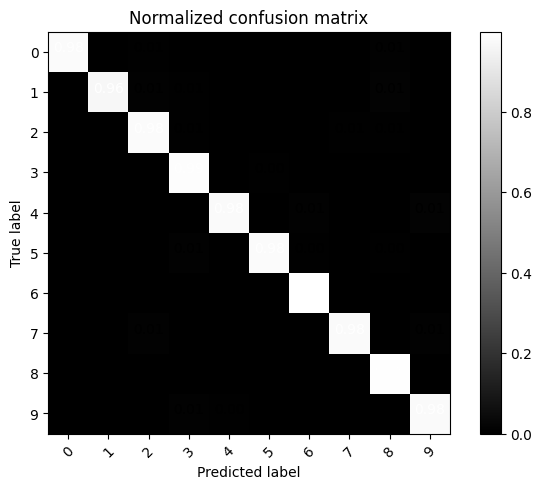

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

Y_pred = model.predict(X_val)
Y_val_pred = lb.inverse_transform(Y_pred)
Y_val_real = lb.inverse_transform(Y_val)
cm = confusion_matrix(Y_val_real, Y_val_pred)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.imshow(cm, cmap = 'gray')
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, np.arange(n_classes), rotation=45)
plt.yticks(tick_marks, np.arange(n_classes))

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [16]:
# Visualizating filters
# https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
from keras import backend as K
import tensorflow as tf

model = load_model('keras_model.h5')

layer_dict = dict([(layer.name, layer) for layer in model.layers])
#print('Layer dict', layer_dict)
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,588 (721.05 KB)

 Trainable params: 184,586 (721.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


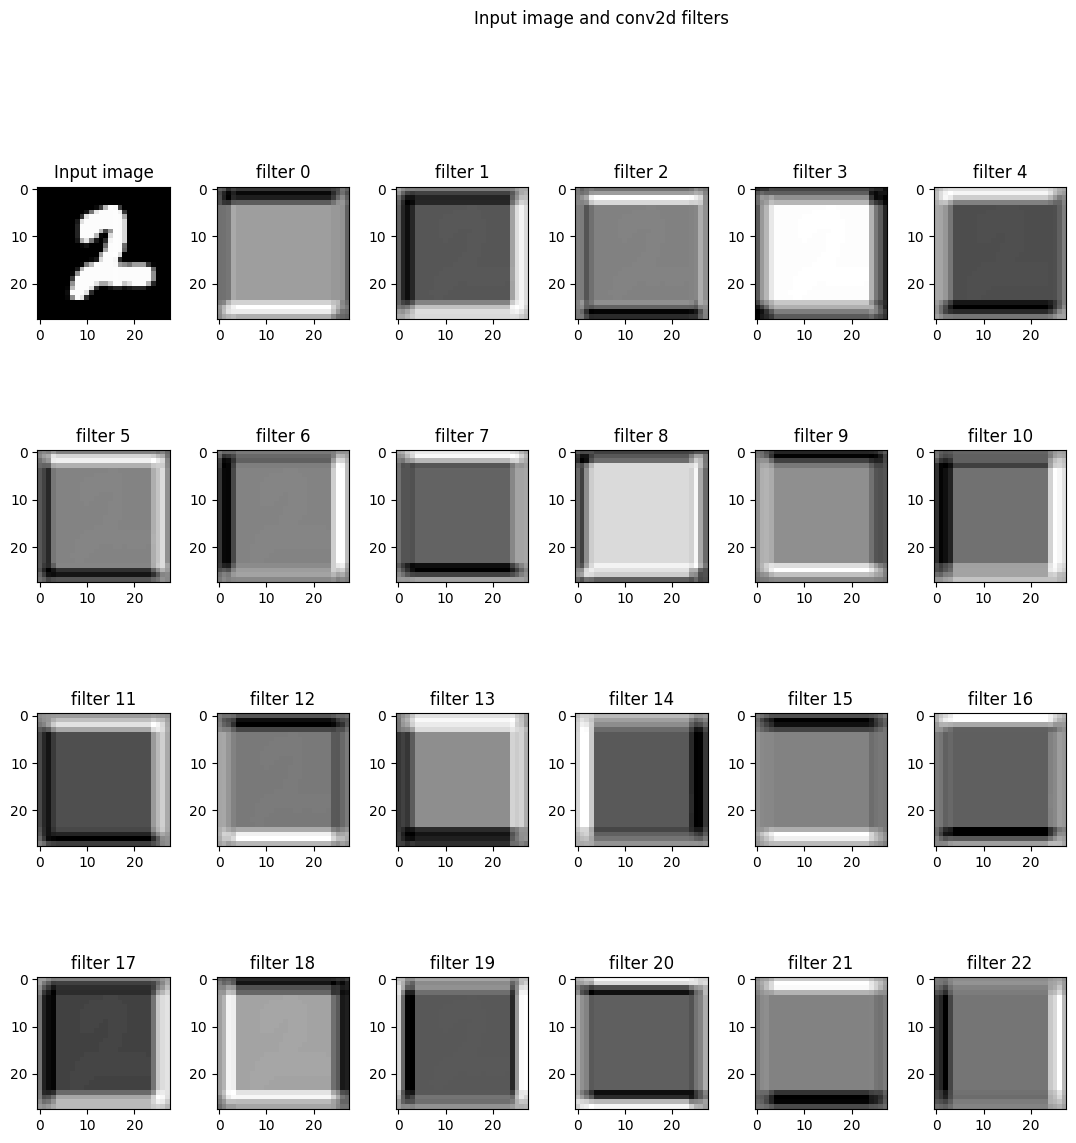

In [17]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[0]).reshape((1, 28, 28, 1)).astype(np.float64),
                      layer_name = 'conv2d'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        # loss = tf.reduce_mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        # grads = tf.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        # grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        # iterate = K.function([model.input], [loss, grads])
        @tf.function
        def iterate(x):
            with tf.GradientTape() as tape:
                tape.watch(x)
                activation = layer_dict[layer_name](x)
                loss = tf.reduce_mean(activation[:, :, :, filter_index])
            grads = tape.gradient(loss, x)[0]
            grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
            return loss, grads


        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            # Convert numpy array to TensorFlow tensor
            img_asc_tensor = tf.constant(img_asc, dtype=tf.float32)
            loss_value, grads_value = iterate(img_asc_tensor)
            img_asc += grads_value.numpy() * step # Convert gradients back to numpy

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))

    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

In [18]:
# Saliency map
# https://github.com/experiencor/deep-viz-keras/blob/master/saliency.py
from keras.layers import Input, Conv2DTranspose
from keras.models import Model
from keras.initializers import Ones, Zeros
import tensorflow as tf
import numpy as np # Import numpy
import os # Import os

class SaliencyMask(object):
    def __init__(self, model, output_index=0):
        self.model = model
        self.output_index = output_index

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):

    def get_mask(self, input_image):
        x_value = np.expand_dims(input_image, axis=0)
        x_value_tensor = tf.constant(x_value, dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(x_value_tensor)
            predictions = self.model(x_value_tensor)
            loss = predictions[:, self.output_index]

        gradients = tape.gradient(loss, x_value_tensor)[0]

        # Save gradients to a temporary file and log the path
        temp_file_path = "/content/gradients.npy"
        np.save(temp_file_path, gradients.numpy())
        yprov4ml.log_artifact("GradientSaliency", temp_file_path)

        return gradients.numpy()


# https://github.com/experiencor/deep-viz-keras/blob/master/visual_backprop.py
class VisualBackprop(SaliencyMask):
    def __init__(self, model, output_index = 0):
        inps = [model.input]           # input placeholder
        outs = [layer.output for layer in model.layers]    # all layer outputs
        self.forward_pass = K.function(inps, outs)         # evaluation function

        self.model = model

    def get_mask(self, input_image):
        x_value = np.expand_dims(input_image, axis=0)

        visual_bpr = None
        layer_outs = self.forward_pass([x_value, 0])

        for i in range(len(self.model.layers) - 1, -1, -1):
            if 'Conv2D' in str(type(self.model.layers[i])):
                layer = np.mean(layer_outs[i], axis = 3, keepdims = True)
                layer = layer - np.min(layer)
                layer = layer / (np.max(layer) - np.min(layer) + 1e-6)

                if visual_bpr is not None:
                    if visual_bpr.shape != layer.shape:
                        visual_bpr = self._deconv(visual_bpr)
                    visual_bpr = visual_bpr * layer
                else:
                    visual_bpr = layer
        yprov4ml.log_artifact("VisualBackprop", visual_bpr[0])
        return visual_bpr[0]

    def _deconv(self, feature_map):
        x = Input(shape = (None, None, 1))
        y = Conv2DTranspose(filters = 1,
                            kernel_size = (3, 3),
                            strides = (2, 2),
                            padding = 'same',
                            kernel_initializer = Ones(),
                            bias_initializer = Zeros())(x)

        deconv_model = Model(inputs=[x], outputs=[y])

        inps = [deconv_model.input]   # input placeholder
        outs = [deconv_model.layers[-1].output]           # output placeholder
        deconv_func = K.function(inps, outs)              # evaluation function

        return deconv_func([feature_map, 0])[0]

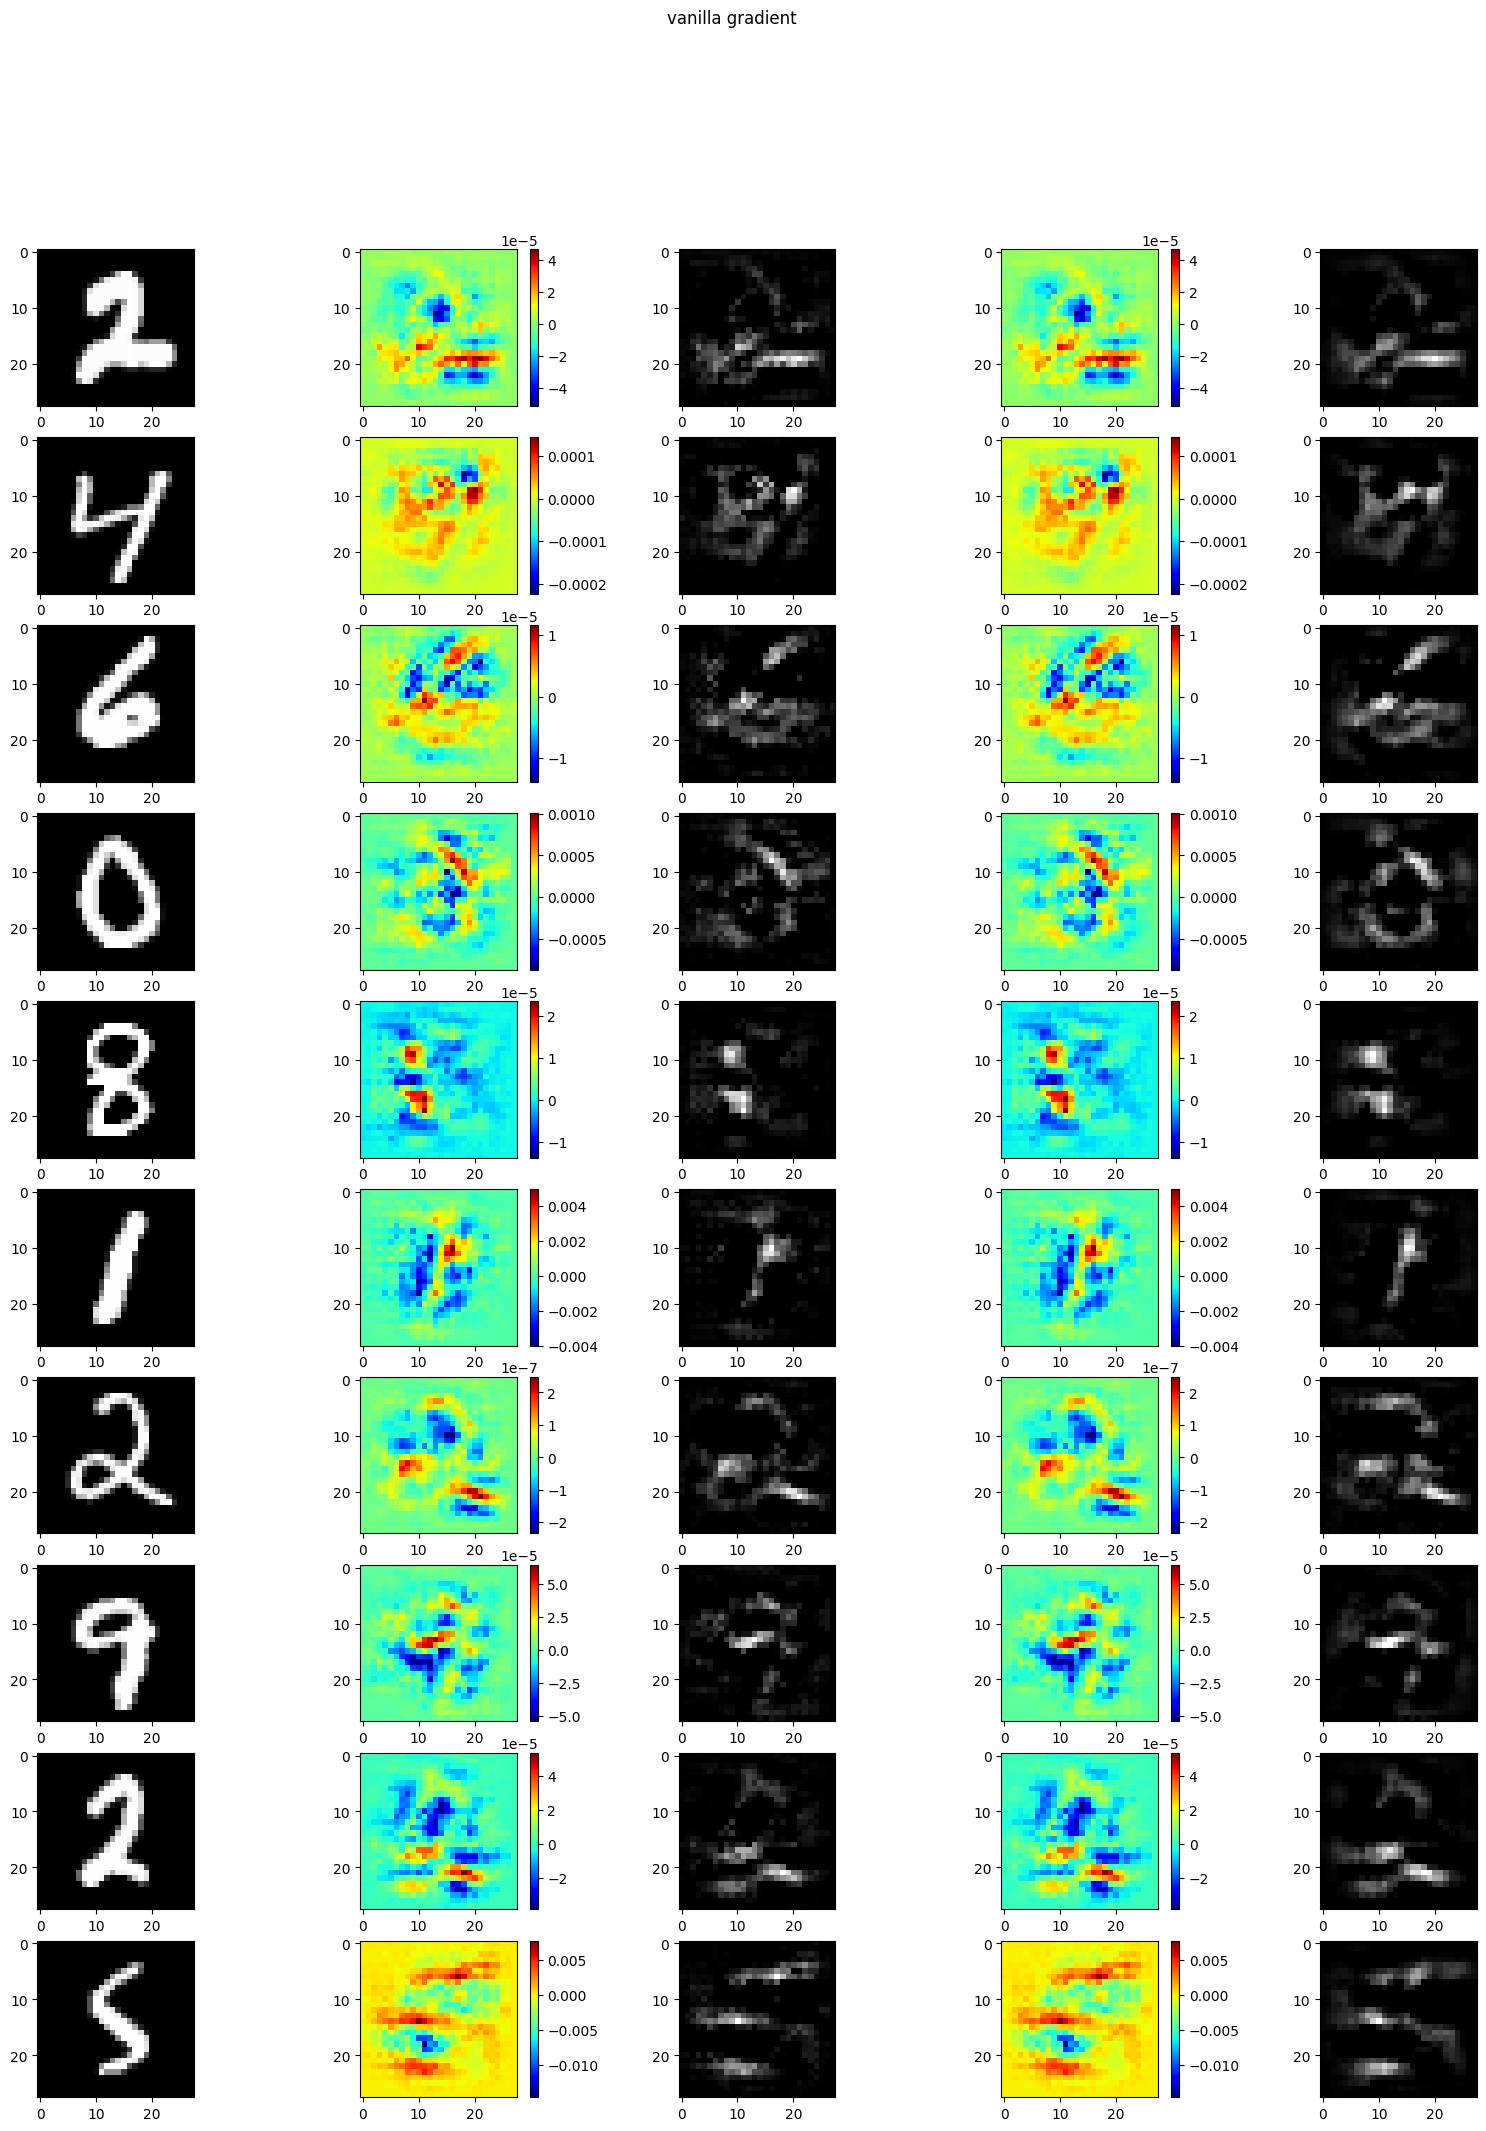

In [19]:
Y_train_label = lb.inverse_transform(Y_train)

fig, ax = plt.subplots(10, 5, figsize = (20, 24)) # Increased figsize for better spacing
fig.suptitle('vanilla gradient')
for i in range(n_classes):
    img = np.array(X_train[i])

    # Build the model by calling it with a sample input
    model(tf.keras.Input(shape=(28, 28, 1)))

    vanilla = GradientSaliency(model, Y_train_label[i])
    mask = vanilla.get_mask(img)
    filter_mask = (mask > 0.0).reshape((28, 28))
    smooth_mask = vanilla.get_smoothed_mask(img)
    filter_smoothed_mask = (smooth_mask > 0.0).reshape((28, 28))

    ax[i, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    cax = ax[i, 1].imshow(mask.reshape((28, 28)), cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 1])
    ax[i, 2].imshow(mask.reshape((28, 28)) * filter_mask, cmap = 'gray')
    cax = ax[i, 3].imshow(mask.reshape((28, 28)), cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 3])
    ax[i, 4].imshow(smooth_mask.reshape((28, 28)) * filter_smoothed_mask, cmap = 'gray')

In [20]:
# End run
yprov4ml.end_run(create_graph=True, create_svg=True)